# Support Vector Machine

## Load Packages and Prep Data

In [57]:
# import needed packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score, confusion_matrix

In [46]:
SVC?

Init signature:
SVC(
    *,
    C=1.0,
    kernel='rbf',
    degree=3,
    gamma='scale',
    coef0=0.0,
    shrinking=True,
    probability=False,
    tol=0.001,
    cache_size=200,
    class_weight=None,
    verbose=False,
    max_iter=-1,
    decision_function_shape='ovr',
    break_ties=False,
    random_state=None,
)
Docstring:     
C-Support Vector Classification.

The implementation is based on libsvm. The fit time scales at least
quadratically with the number of samples and may be impractical
beyond tens of thousands of samples. For large datasets
consider using :class:`~sklearn.svm.LinearSVC` or
:class:`~sklearn.linear_model.SGDClassifier` instead, possibly after a
:class:`~sklearn.kernel_approximation.Nystroem` transformer.

The multiclass support is handled according to a one-vs-one scheme.

For details on the precise mathematical formulation of the provided
kernel functions and how `gamma`, `coef0` and `degree` affect each
other, see the corresponding section in the narrati

In [33]:
# load data
train_data = pd.read_csv('data/train_data_fe.csv')
test_data = pd.read_csv('data/test_data_fe.csv')
print(train_data.shape)
print(test_data.shape)

(62889, 46)
(15723, 46)


In [34]:
# drop unneeded columns
train_data.drop(['stone_soil', 'id', 'img_id'], axis=1, inplace = True)
test_data.drop(['stone_soil', 'id', 'img_id'], axis=1, inplace = True)

In [35]:
# prep data
y_train = train_data['stone_soil_enc']
X_train = train_data.drop(['stone_soil_enc'], axis=1)
y_test = test_data['stone_soil_enc']
X_test = test_data.drop(['stone_soil_enc'], axis=1)

In [36]:
# define a function for scoring
def pred_metrics(real, pred) -> None:
    print("Accuracy:\t{}".format(accuracy_score(real, pred)))
    print("Precision:\t{}".format(precision_score(real, pred)))
    print("Recall:\t\t{}".format(recall_score(real, pred)))
    print("F1:\t\t{}".format(f1_score(real, pred)))

## Model 1
- Defaults

In [37]:
# fit SVM model
svm_1 = SVC()
x = svm_1.fit(X_train, y_train)

In [38]:
# cross validation
# low f1 score indicates low precision and low recall
score = cross_val_score(svm_1, X_train, y_train, scoring = "f1")
print(score.round(decimals=4))
print(score.mean().round(decimals=4))

[0.5392 0.5437 0.5437 0.5471 0.5444]
0.5436


## Model 2
- Regularize by removing correlated features

### Feature Selection

In [41]:
# drop correlated features

correlated_features = set()
correlation_matrix = X_train.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

print('Number of redundant features:',len(correlated_features))
print('Removed features:',correlated_features)
print()
X_train_selected = X_train.drop(columns = correlated_features)
print('Remaining features:',list(X_train_selected.columns))

Number of redundant features: 31
Removed features: {'fwidth', 'w_l_ratio', 'roundness', 'surface_area', 'thick_vol_prod', 'rnd_ell_prod', 'ellipticity', 'chull_area', 'concavity', 'ellipse_ratio', 'dp', 'circularity', 'sieve', 'chull_perimeter', 'fiber_width', 'compactness', 'fthickness', 'chull_surface_area', 'ethickness', 't_l_aspect_ratio', 'thick_perm_prod', 'l_w_ratio', 'l_t_ratio', 'angularity', 'elength', 't_w_ratio', 'ewidth', 'perimeter', 'flength', 'area', 'fiber_length'}

Remaining features: ['da', 'volume', 'sphericity', 'solidity', 'convexity', 'extent', 'transparency', 'curvature', 'w_t_ratio', 'krumbein_rnd', 'thick_trans_prod']


### Fit Model

In [44]:
# fit SVM model
svm_2 = SVC()
x = svm_2.fit(X_train_selected, y_train)

### Cross-Validation

In [45]:
# cross validation
# low f1 score indicates low precision and low recall
score = cross_val_score(svm_2, X_train_selected, y_train, scoring = "f1")
print(score.round(decimals=4))
print(score.mean().round(decimals=4))

[0.4885 0.4842 0.493  0.4963 0.4795]
0.4883


## Model 3
- Hyperparameter tuning by grid search (could try `RandomizedSearchCV`)

### Grid Search

In [47]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C':[1.0, 10.0, 100.0, 1000.0], 'gamma':[0.001, 0.0001], 'kernel':['rbf', 'linear']}

In [48]:
svm = SVC()

In [50]:
grid_search = GridSearchCV(svm, param_grid, cv = 5, scoring = 'f1',return_train_score=True)
x = grid_search.fit(X_train_selected,y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1.0, 10.0, 100.0, 1000.0],
                         'gamma': [0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             return_train_score=True, scoring='f1')

In [52]:
# scores with each set of parameters
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.0 {'C': 1.0, 'gamma': 0.001, 'kernel': 'rbf'}
0.07170820949513906 {'C': 1.0, 'gamma': 0.001, 'kernel': 'linear'}
0.0 {'C': 1.0, 'gamma': 0.0001, 'kernel': 'rbf'}
0.07170820949513906 {'C': 1.0, 'gamma': 0.0001, 'kernel': 'linear'}
0.0 {'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'}
0.09285023017898461 {'C': 10.0, 'gamma': 0.001, 'kernel': 'linear'}
0.0 {'C': 10.0, 'gamma': 0.0001, 'kernel': 'rbf'}
0.09285023017898461 {'C': 10.0, 'gamma': 0.0001, 'kernel': 'linear'}
0.026202303794624328 {'C': 100.0, 'gamma': 0.001, 'kernel': 'rbf'}
0.0937138866653483 {'C': 100.0, 'gamma': 0.001, 'kernel': 'linear'}
0.0 {'C': 100.0, 'gamma': 0.0001, 'kernel': 'rbf'}
0.0937138866653483 {'C': 100.0, 'gamma': 0.0001, 'kernel': 'linear'}
0.08044069072199443 {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'}
0.09369123866063753 {'C': 1000.0, 'gamma': 0.001, 'kernel': 'linear'}
0.026202303794624328 {'C': 1000.0, 'gamma': 0.0001, 'kernel': 'rbf'}
0.09369123866063753 {'C': 1000.0, 'gamma': 0.0001, 'kernel': 'linear'}


In [53]:
# best parameters
grid_search.best_params_

{'C': 100.0, 'gamma': 0.001, 'kernel': 'linear'}

In [54]:
# store best model
svm_tuned = grid_search.best_estimator_

SVC(C=100.0, gamma=0.001, kernel='linear')

In [58]:
# cross validation
# low f1 score indicates low precision and low recall
score = cross_val_score(svm_tuned, X_train_selected, y_train, scoring = "f1")
print(score.round(decimals=4))
print(score.mean().round(decimals=4))

[0.1009 0.0881 0.0902 0.101  0.0883]
0.0937


## Test

In [56]:
# test the performance of the selected model
y_pred = svm_tuned.predict(X_test.drop(columns = correlated_features))
pred_metrics(y_test,y_pred)

Accuracy:	0.9335368568339375
Precision:	0.8225806451612904
Recall:		0.047004608294930875
F1:		0.08892763731473408


<AxesSubplot:>

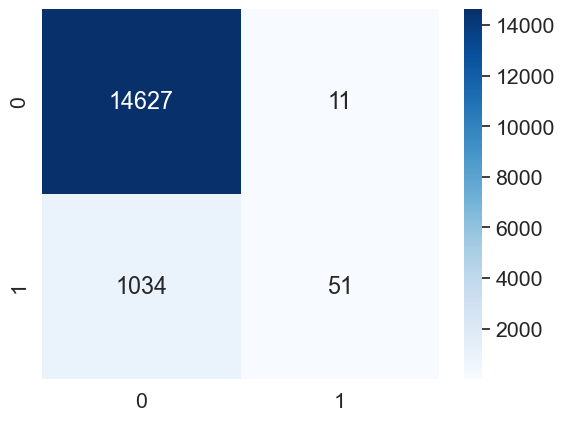

In [60]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt = 'g', cmap = 'Blues')